## **0. Download dataset**


In [1]:
# https://drive.google.com/file/d/1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V/view?usp=sharing
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 10.9MB/s]


## **1. Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## **2. Read dataset**

In [3]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [4]:
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(300, 2)
[[0.         0.        ]
 [0.00096008 0.01005528]
 [0.01045864 0.01728405]
 [0.00087922 0.03029027]
 [0.00991727 0.03916803]]
(300,)
[0 0 0 0 0]


**2.1 Visualize**

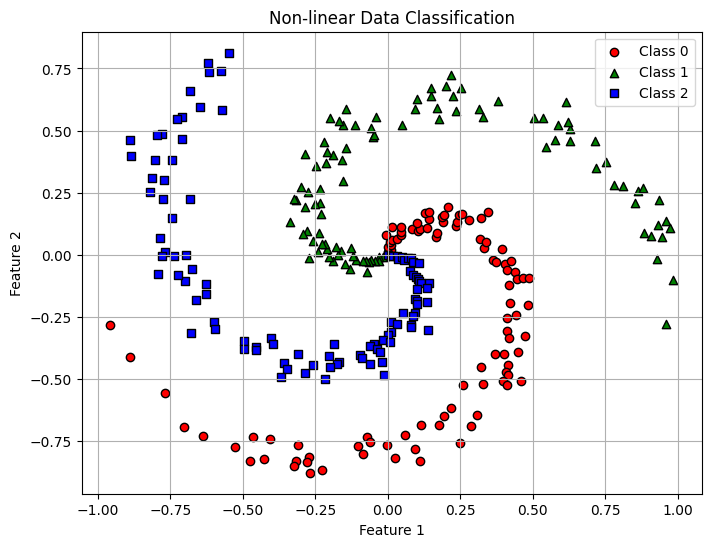

In [5]:
colors = ['red', 'green', 'blue']
markers = ['o', '^', 's']

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(np.unique(y)):
    plt.scatter(
        X[y == class_label, 0],
        X[y == class_label, 1],
        c=colors[i],
        marker=markers[i],
        label=f'Class {class_label}',
        edgecolor='k'
    )

plt.title("Non-linear Data Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


## **3. Train/val/test split**

In [6]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [7]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 210
Number of val samples: 60
Number of test samples: 30


## **4. Data Normalization**

In [8]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

## **5. Create PyTorch DataLoader**

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **6. Build MLP network**

In [12]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    out = self.output(x)
    return out.squeeze(1)

In [14]:
input_dims = X_train.shape[1]
hidden_dims = 128
output_dims = torch.unique(y_train).shape[0]
lr = 1e-1


model = MLP(input_dims, hidden_dims, output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [19]:
def compute_accuracy(y_hat, y_true):
  _, predict = torch.max(y_hat, dim=1)
  correct = (predict == y_true).sum().item()
  accuracy = correct / len(y_true)
  return accuracy

In [20]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.711	Validation loss: 0.809

EPOCH 2:	Training loss: 0.699	Validation loss: 0.786

EPOCH 3:	Training loss: 0.684	Validation loss: 0.780

EPOCH 4:	Training loss: 0.667	Validation loss: 0.776

EPOCH 5:	Training loss: 0.636	Validation loss: 0.718

EPOCH 6:	Training loss: 0.606	Validation loss: 0.696

EPOCH 7:	Training loss: 0.603	Validation loss: 0.679

EPOCH 8:	Training loss: 0.592	Validation loss: 0.648

EPOCH 9:	Training loss: 0.556	Validation loss: 0.650

EPOCH 10:	Training loss: 0.554	Validation loss: 0.629

EPOCH 11:	Training loss: 0.543	Validation loss: 0.595

EPOCH 12:	Training loss: 0.535	Validation loss: 0.583

EPOCH 13:	Training loss: 0.524	Validation loss: 0.570

EPOCH 14:	Training loss: 0.504	Validation loss: 0.552

EPOCH 15:	Training loss: 0.497	Validation loss: 0.535

EPOCH 16:	Training loss: 0.484	Validation loss: 0.522

EPOCH 17:	Training loss: 0.463	Validation loss: 0.514

EPOCH 18:	Training loss: 0.470	Validation loss: 0.503

EPOCH 19:	Training

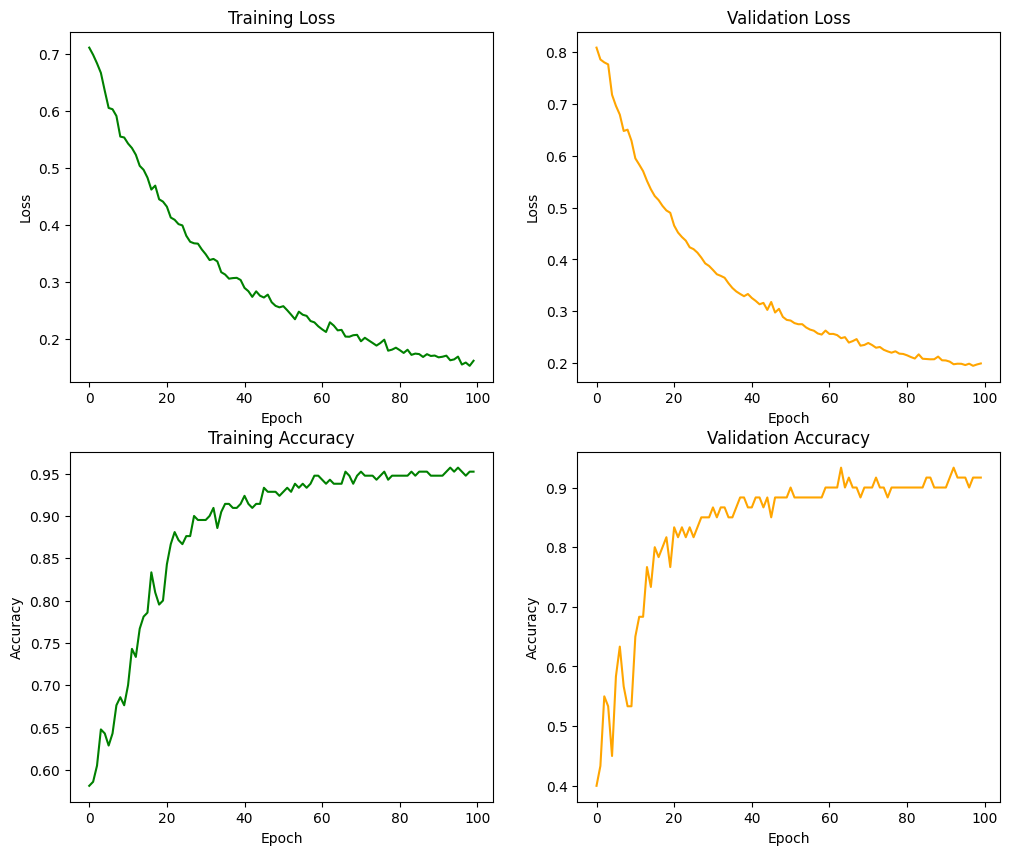

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **8. Evaluation**

In [23]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9
